# 02 - Exploratory Data Analysis

___

### 02.1 - Importando as bibliotecas

In [852]:
# Bibliotecas básicas
import os
import numpy as np
import pandas as pd
from datetime import datetime  
from datetime import timedelta

# Bibliotecas para visualização de dados
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Bibliotecas para trabalhar com séries temporais
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

# Bibliotecas de machine learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Métrica de avaliação
from sklearn.metrics import mean_squared_error

# Configurando a largura das células do notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Configurando o tamanho dos plots do matplotlib
import matplotlib
matplotlib.rcParams['figure.figsize'] = [21, 6]

# Silenciando os warnings
import warnings
warnings.filterwarnings('ignore')

### 02.2 - Definindo os caminhos

In [3]:
THIS_PATH = os.getcwd()
ROOT_PATH = os.path.dirname(THIS_PATH)
DATA_PATH = os.path.join(ROOT_PATH, 'data')

### 02.3 - Carregando os dados

In [4]:
stocks_file = os.path.join(DATA_PATH, 'stocks.csv')
stocks_df = pd.read_csv(stocks_file)

In [5]:
stocks_df.head(2)

Date     High      Low     Open    Close   Volume  Adj Close Ticker
0  2005-01-03  4.58232  4.58232  4.58232  4.58232  40041.0   0.825290  ABEV3
1  2005-01-04  4.61528  4.61528  4.61528  4.61528  72498.0   0.831226  ABEV3

Nesta análise exploratória, antes de tudo, vamos avaliar se existem padrões que podem ser previstos nos preços das ações. Portanto, a princípio, para facilitar, limitaremos a quantidade de papéis a serem analisados. Se concluirmos que há padrões significativos, podemos extrapolar as análises para as demais empresas. Sendo assim, por motivo de gosto particular, escolhi analisar as empresas do setor financeiro, isto é, bancos.

In [6]:
setor_file = os.path.join(DATA_PATH, 'setores.csv')
setor_df = pd.read_csv(setor_file)
setor_df.drop('Unnamed: 0', axis=1, inplace=True)

In [7]:
setor_df.head(2)

Ticker       Setor                  Subsetor
0  ABEV3     Bebidas  Cervejas e Refrigerantes
1  AZUL4  Transporte          Transporte Aéreo

### 02.4 - Filtrando os dados

In [8]:
tickers_bancos = setor_df[setor_df['Subsetor'] == 'Bancos']['Ticker'].to_list()

In [9]:
# Vamos filtrar a tabela de stocks para conter apenas bancos
df_bancos = stocks_df[stocks_df['Ticker'].isin(tickers_bancos)].reset_index(drop=True)

In [10]:
df_bancos[df_bancos['Ticker'] == 'BBAS3'].tail(10)

Date       High        Low       Open      Close      Volume  \
3854  2020-07-28  35.779999  34.549999  34.700001  35.029999  17055500.0   
3855  2020-07-29  35.950001  35.150002  35.380001  35.950001  13101300.0   
3856  2020-07-30  35.540001  34.520000  35.119999  34.799999  23154800.0   
3857  2020-07-31  34.970001  33.570000  34.900002  33.580002  20701300.0   
3858  2020-08-03  35.040001  33.779999  34.240002  34.349998  24030700.0   
3859  2020-08-04  34.599998  33.009998  33.880001  33.299999  20774400.0   
3860  2020-08-05  33.970001  32.900002  33.810001  33.330002  14184600.0   
3861  2020-08-06  34.430000  33.139999  33.759998  34.349998  18267300.0   
3862  2020-08-07  34.939999  33.599998  34.000000  34.110001  18561800.0   
3863  2020-08-10  34.599998  33.750000  34.119999  34.430000   9726000.0   

      Adj Close Ticker  
3854  35.029999  BBAS3  
3855  35.950001  BBAS3  
3856  34.799999  BBAS3  
3857  33.580002  BBAS3  
3858  34.349998  BBAS3  
3859  33.299999  BBAS3  
3860  33.330002  BBAS3  
3861  34.349998  BBAS3  
3862  34.110001  BBAS3  
3863  34.430000  BBAS3

In [11]:
df_bancos['Ticker'].unique()

array(['BBAS3', 'BBDC3', 'BBDC4', 'BPAC11', 'ITSA4', 'ITUB4', 'SANB11'],
      dtype=object)

### 02.5 - Arrumando os dados

O dado temporal que iremos analisar será o valor ajustado de fechamento das ações, ou seja, a coluna 'Adj Close'. Portanto, vamos arrumar o layout do DataFrame para que possamos comparar as empresas.

In [12]:
# Apagando as colunas que não utilizaremos nesta análise
cols_drop = ['High', 'Low', 'Open', 'Close', 'Volume']
df_bancos.drop(cols_drop, axis=1, inplace=True)

In [13]:
df_bancos.tail(2)

Date  Adj Close  Ticker
22013  2020-08-07      29.25  SANB11
22014  2020-08-10      30.34  SANB11

In [14]:
# Colocando as empresas lado a lado
tickers = df_bancos['Ticker'].unique().tolist()

In [15]:
tickers

['BBAS3', 'BBDC3', 'BBDC4', 'BPAC11', 'ITSA4', 'ITUB4', 'SANB11']

In [16]:
df_bancos_fixed = pd.DataFrame()

for t in tickers:
    aux = df_bancos[df_bancos['Ticker'] == t].reset_index(drop=True)
    aux.rename(columns={'Adj Close': t}, inplace=True)
    aux.drop('Ticker', axis=1, inplace=True)
    
    if len(df_bancos_fixed) == 0:
        df_bancos_fixed = aux
    else:
        df_bancos_fixed = df_bancos_fixed.merge(aux, how='outer', on='Date').sort_values(by='Date')

In [17]:
df_bancos_fixed.tail(3)

Date      BBAS3      BBDC3      BBDC4     BPAC11  ITSA4  \
3875  2020-08-06  34.349998  20.420000  21.969999  89.639999  10.32   
3876  2020-08-07  34.110001  20.290001  21.840000  88.139999  10.21   
3877  2020-08-10  34.430000  20.459999  22.030001  88.459999  10.36   

          ITUB4     SANB11  
3875  26.030001  29.593403  
3876  25.480000  29.250000  
3877  25.809999  30.340000

In [18]:
# Removendo papéis de empresas iguais
cols_drop = ['BBDC3', 'ITSA4']
df_bancos_fixed.drop(cols_drop, axis=1, inplace=True)

In [19]:
df_bancos_fixed.tail(3)

Date      BBAS3      BBDC4     BPAC11      ITUB4     SANB11
3875  2020-08-06  34.349998  21.969999  89.639999  26.030001  29.593403
3876  2020-08-07  34.110001  21.840000  88.139999  25.480000  29.250000
3877  2020-08-10  34.430000  22.030001  88.459999  25.809999  30.340000

In [20]:
# As ações da empresa 'BPAC11' tem um histórico relativamente pequeno (a partir de 2017)
df_bancos_fixed[~df_bancos_fixed['BPAC11'].isnull()][['Date']].min()

Date    2017-02-24
dtype: object

In [21]:
# Por isso, vamos removê-la também
df_bancos_fixed.drop('BPAC11', axis=1, inplace=True)

In [22]:
df_bancos_fixed.tail(2)

Date      BBAS3      BBDC4      ITUB4  SANB11
3876  2020-08-07  34.110001  21.840000  25.480000   29.25
3877  2020-08-10  34.430000  22.030001  25.809999   30.34

In [23]:
# Salvando a base tratada
df_bancos_fixed_filename = 'exploratory-data.csv'
df_bancos_fixed.to_csv(os.path.join(DATA_PATH, df_bancos_fixed_filename), index=False)

### 02.5 - Explorando os dados

In [305]:
# Carregando a base tratada
df_bancos_fixed_filename = 'exploratory-data.csv'
exp_data = pd.read_csv(os.path.join(DATA_PATH, df_bancos_fixed_filename))

In [306]:
exp_data.tail(2)

Date      BBAS3      BBDC4      ITUB4  SANB11
3876  2020-08-07  34.110001  21.840000  25.480000   29.25
3877  2020-08-10  34.430000  22.030001  25.809999   30.34

In [307]:
# Setando Date como o index
exp_data.set_index('Date', inplace=True)

In [308]:
exp_data.tail(2)

BBAS3      BBDC4      ITUB4  SANB11
Date                                               
2020-08-07  34.110001  21.840000  25.480000   29.25
2020-08-10  34.430000  22.030001  25.809999   30.34

In [309]:
tickers = exp_data.columns.to_list()

In [310]:
tickers

['BBAS3', 'BBDC4', 'ITUB4', 'SANB11']

#### Cotação x Tempo

In [311]:
fig = go.Figure()

for t in tickers:
    fig.add_trace(go.Scatter(x=exp_data.index, y=exp_data[t], mode='lines', name=t))

fig.update_layout(
    title={
        'text': 'Cotação x Tempo',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Tempo',
    yaxis_title='Cotação (R$)',
    legend_title='Ticker',
    font=dict(
        family='Courier New, monospace',
        size=18,
        color='Black'
    ),
#     template='plotly_white'
)
fig.show()

#### Pairplot

In [312]:
fig = px.scatter_matrix(exp_data, dimensions=tickers)

fig.update_layout(
    title={
        'text': 'Análise de Correlação',
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    font=dict(
        family='Courier New, monospace',
        size=15,
        color='Black'
    ),
#     template='plotly_white',
    width=1320,
    height=600
)

# fig.update_xaxes(xaxis={'showgrid': False})
# fig.update_yaxes(yaxis={'showgrid': False})

fig.show()

#### Correlação de Pearson

In [313]:
corr = exp_data.corr()
X = tickers
heat = go.Heatmap(
    z=corr,
    x=X,
    y=X,
    xgap=1, ygap=1,
    colorscale=[[0.0, '#3f7f93']],
    colorbar_thickness=20,
    colorbar_ticklen=5,
#     hovertext =hovertext,
    hoverinfo='text'
)

layout = go.Layout(
    title_text='Matriz de Correlação de Pearson',
    title_x=0.5, 
    width=800, height=600,
    yaxis_autorange='reversed',
#     template='plotly_dark',
    font=dict(
        family='Courier New, monospace',
        size=15,
        color='Black'
    ),
    coloraxis_colorbar=(dict(
        dtick=0.1
    )))

fig=go.Figure(data=heat, layout=layout)        
fig.show()

#### Candlesticks

In [314]:
stocks_df.tail(2)

Date       High        Low       Open      Close     Volume  \
225819  2020-08-07  33.180000  31.809999  32.970001  32.180000  3020900.0   
225820  2020-08-10  32.459999  31.350000  32.349998  32.029999  3154200.0   

        Adj Close Ticker  
225819  32.180000  YDUQ3  
225820  32.029999  YDUQ3

In [315]:
def candlestick(ticker):
    aux = stocks_df[stocks_df['Ticker'] == ticker]
    
    fig = go.Figure(data=[go.Candlestick(x=aux['Date'],
                    open=aux['Open'],
                    high=aux['High'],
                    low=aux['Low'],
                    close=aux['Close'])])
    
    fig.update_layout(
        title={
            'text': 'Candlestick do {}'.format(ticker),
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        font=dict(
            family='Courier New, monospace',
            size=18,
            color='Black'
        ),
    #     template='plotly_dark'
    )
    
    fig.show()

In [316]:
candlestick('SANB11')

#### Estatísticas de posição

In [317]:
fig = go.Figure()

for t in tickers:
    fig.add_trace(go.Violin(y=exp_data[t],
                            name=t,
                            box_visible=True,
                            meanline_visible=True))
    
    fig.update_layout(
        title={
            'text': f'Distribuições das cotações históricas',
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        font=dict(
            family='Courier New, monospace',
            size=18,
            color='Black'
        )
    )
        
fig.show()

#### Distribuições

In [318]:
def plot_hist(data, ticker):
    fig = px.histogram(data, x=ticker, marginal='violin', # can be `box`, `violin`
                       hover_data=exp_data.columns)
    fig.update_traces(opacity=0.6)
    fig.update_layout(
        title={
            'text': f'\nDistribuição das cotações históricas de {ticker}',
            'y':1.0,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        font=dict(
            family='Courier New, monospace',
            size=18,
            color='Black'
        ),
        xaxis_title_text='Cotação (R$)',
        yaxis_title_text='Quantidade',
    #     bargap=0.2, # gap between bars of adjacent location coordinates
    #     bargroupgap=0.1 # gap between bars of the same location coordinates
    )
    print('\n')
    fig.show()

In [319]:
plot_hist(exp_data, 'SANB11')

### 02.6 - Tratando os dados

#### Definindo o período

In [320]:
per = pd.DataFrame()
ini = []
fim = []

for c in exp_data.columns:
#     print(c, 'Data inicial: ', exp_data[~exp_data[c].isnull()].index.min(), '// Data final:', exp_data[~exp_data[c].isnull()].index.max())
    ini.append(exp_data[~exp_data[c].isnull()].index.min())
    fim.append(exp_data[~exp_data[c].isnull()].index.max())
    
per['Ticker'] = exp_data.columns
per['Dt_Ini'] = ini
per['Dt_Fim'] = fim

In [321]:
per

Ticker      Dt_Ini      Dt_Fim
0   BBAS3  2005-01-03  2020-08-10
1   BBDC4  2008-01-02  2020-08-10
2   ITUB4  2005-01-03  2020-08-10
3  SANB11  2009-10-07  2020-08-10

BBAS3 e ITUB4 possuem valores desde 2005. BBDC4, a partir de 2008. E SANB11, a partir do final de 2009. Portanto, vamos considerar de 2010 para frente. Assim, teremos um bom período para analisar e não consideramos dados muitos antigos, que tendem a ter pouca influência sobre os dados mais recentes.

In [322]:
exp_data.shape

(3878, 4)

In [323]:
# Removendo os dados anteriores a 2010
exp_data.drop(exp_data[exp_data.index < '2010-01-01'].index, axis=0, inplace=True)

In [324]:
exp_data.head(2)

BBAS3     BBDC4      ITUB4     SANB11
Date                                                 
2010-01-04  16.643383  9.713889  12.350099  14.976392
2010-01-05  16.476391  9.671092  12.430142  15.121425

In [325]:
exp_data.shape

(2629, 4)

#### Tratamento de missings

In [326]:
exp_data.isnull().sum() / len(exp_data) * 100

BBAS3     0.494485
BBDC4     1.255230
ITUB4     0.456447
SANB11    0.418410
dtype: float64

Nota-se que não existem muitos valores missing. Neste caso, como podemos observar comportamento de tendência nas séries temporais, vamos utilizar o método de interpolação linear.

In [327]:
exp_data[exp_data['ITUB4'].isnull()]

BBAS3      BBDC4  ITUB4     SANB11
Date                                              
2010-05-28  14.856873  11.082592    NaN  11.905439
2011-10-25        NaN        NaN    NaN        NaN
2011-10-26        NaN        NaN    NaN        NaN
2011-10-27        NaN        NaN    NaN        NaN
2011-11-10        NaN        NaN    NaN        NaN
2011-12-12        NaN        NaN    NaN        NaN
2012-01-17        NaN        NaN    NaN        NaN
2012-02-13  15.877047   8.670382    NaN  11.674769
2012-03-19  17.388380   9.088017    NaN  12.589262
2012-04-11  14.877537   8.514096    NaN  10.581585
2012-05-16  12.377570   7.811274    NaN  10.735913
2012-05-21  12.966115   8.047462    NaN  10.474225

In [333]:
exp_data.loc['2011-11-05':'2011-11-15']

BBAS3     BBDC4      ITUB4    SANB11
Date                                                
2011-11-07  15.251719  8.524333  10.300629  9.914286
2011-11-08  15.209821  8.579308  10.284811  9.907701
2011-11-09  14.796803  8.441819  10.025695  9.683873
2011-11-10        NaN       NaN        NaN       NaN
2011-11-11  14.647154  8.400558  10.060467  9.789206
2011-11-14  15.143975  8.524333  10.085726  9.677289

In [335]:
(10.025695 + 10.060467) / 2

10.043081

In [334]:
exp_data.interpolate(method='linear').loc['2011-11-10']

BBAS3     14.721978
BBDC4      8.421189
ITUB4     10.043081
SANB11     9.736539
Name: 2011-11-10, dtype: float64

In [336]:
exp_data.interpolate(method='linear', axis=0, inplace=True)

In [337]:
exp_data.isnull().sum()

BBAS3     0
BBDC4     0
ITUB4     0
SANB11    0
dtype: int64

#### Autocorrelação

In [338]:
exp_data.head(2)

BBAS3     BBDC4      ITUB4     SANB11
Date                                                 
2010-01-04  16.643383  9.713889  12.350099  14.976392
2010-01-05  16.476391  9.671092  12.430142  15.121425

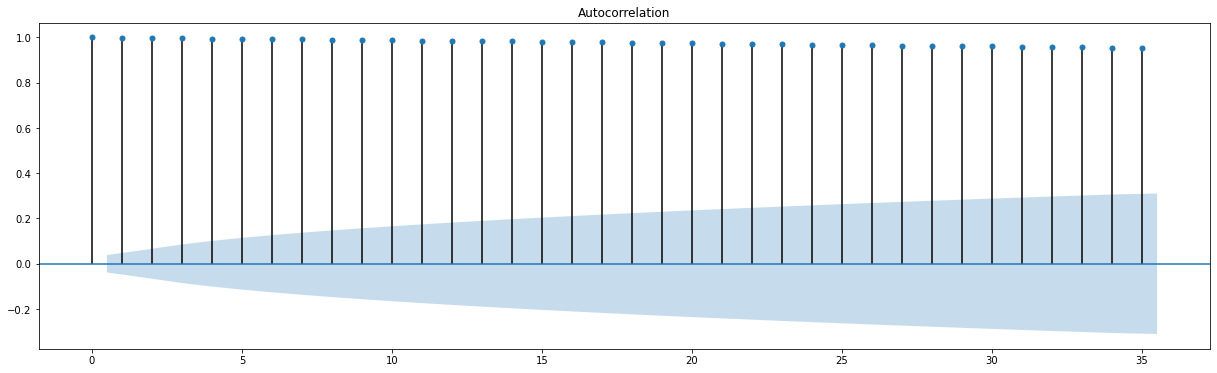

In [340]:
# autocorr = exp_data
ax = plot_acf(exp_data['ITUB4'], alpha = 0.05); # não pode ter nulos

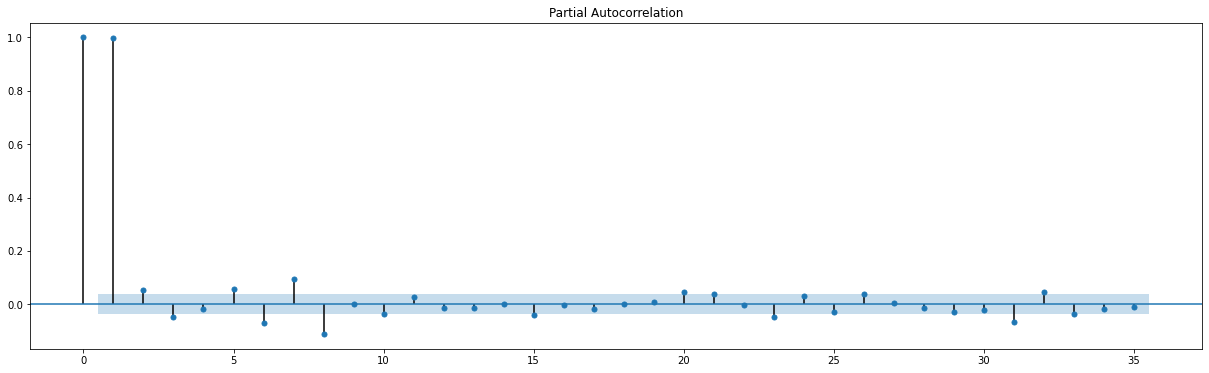

In [342]:
# autocorr = exp_data
ax = plot_pacf(exp_data['BBAS3'], alpha = 0.05); # não pode ter nulos

#### Autocorrelação na série estacionária

In [352]:
# série não estacionária
exp_data['ITUB4'].tail().to_frame()

ITUB4
Date                 
2020-08-04  25.690001
2020-08-05  25.670000
2020-08-06  26.030001
2020-08-07  25.480000
2020-08-10  25.809999

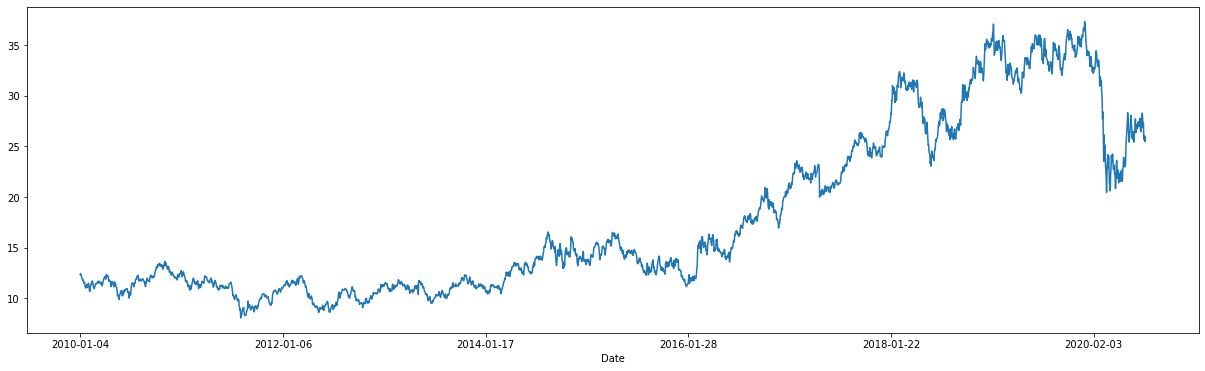

In [344]:
exp_data['ITUB4'].plot();

In [345]:
# série estacionária
exp_data_estac = exp_data.copy()
exp_data_estac['ITUB4_DIFF'] = exp_data_estac['ITUB4'].pct_change()

In [354]:
exp_data_estac[['ITUB4', 'ITUB4_DIFF']].tail()

ITUB4  ITUB4_DIFF
Date                             
2020-08-04  25.690001   -0.058284
2020-08-05  25.670000   -0.000779
2020-08-06  26.030001    0.014024
2020-08-07  25.480000   -0.021130
2020-08-10  25.809999    0.012951

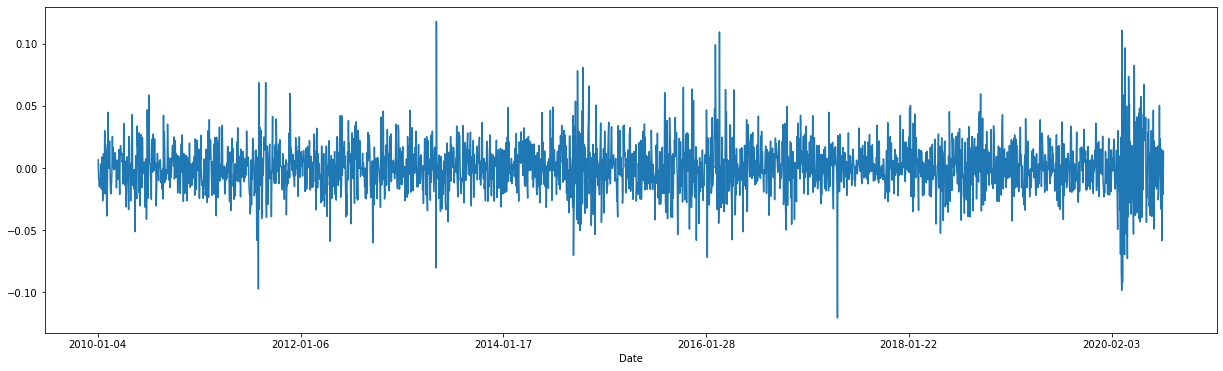

In [355]:
exp_data_estac['ITUB4_DIFF'].plot();

In [360]:
# Teste de Dickey-Fuller
adfuller_itub = adfuller(exp_data_estac['ITUB4_DIFF'].dropna())
print(np.round(adfuller_itub[1],3))

0.0


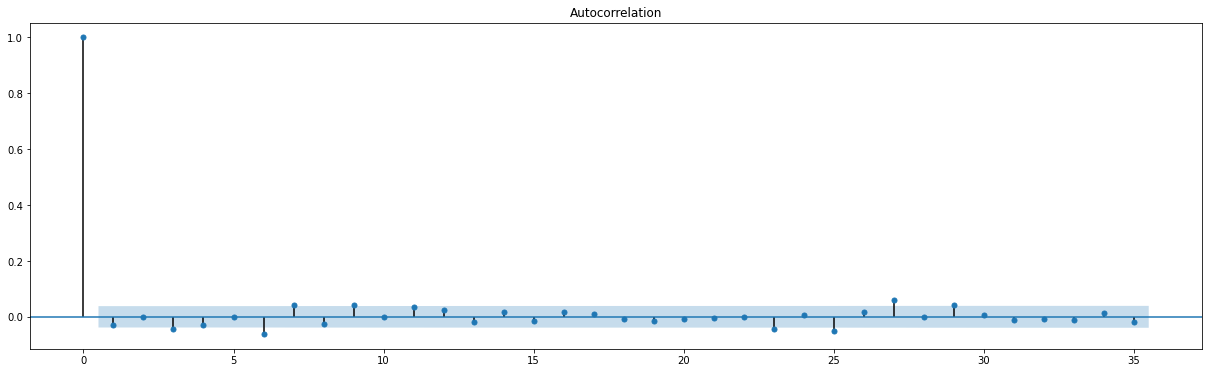

In [361]:
# Analisando a autocorrelação na série estacionária
ax = plot_acf(exp_data_estac['ITUB4_DIFF'].dropna(), alpha = 0.05); # não pode ter nulos

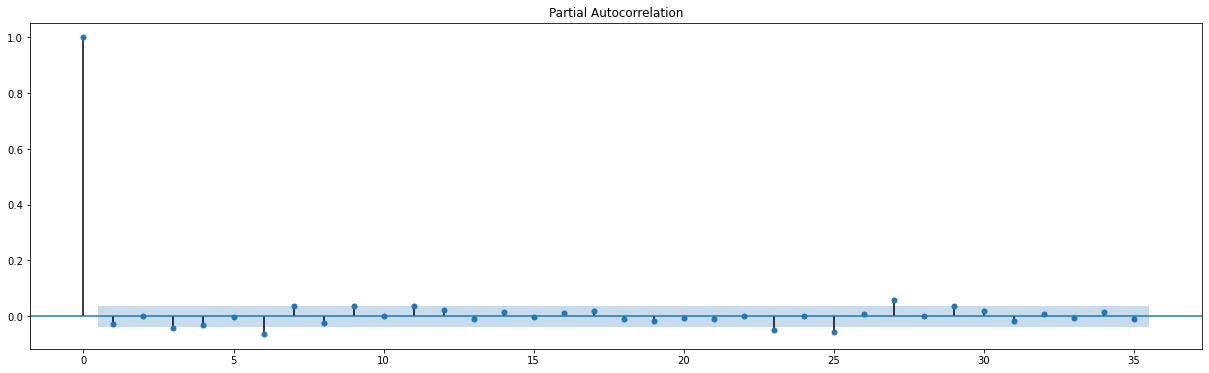

In [362]:
# Analisando a autocorrelação na série estacionária
ax = plot_pacf(exp_data_estac['ITUB4_DIFF'].dropna(), alpha = 0.05); # não pode ter nulos

Notamos que a autocorrelação na série estacionária é praticamente igual a zero, o que indica que a série (pelo menos na visão diária) é imprevisível, o que classificamos como White Noise (ou Ruído Branco).

### 02.7 Modelagem básica

Vamos testar algums abordagens de séries temporais mais básicas e compará-las com uma baseline. Nesta etapa, vamos abordar as previsões com os seguintes métodos:

- Baseline
- ARIMA
- Regressão Linear
- Random Forest

Estas abordagens serão aplicadas em 4 diferentes agrupamentos das séries temporais:

- Diário
- Semanal
- Mensal
- Trimestral

In [363]:
# Primeiro, vamos criar as bases de séries temporais com agrupamentos distintos, conforme listado acima
exp_data.head()

BBAS3     BBDC4      ITUB4     SANB11
Date                                                 
2010-01-04  16.643383  9.713889  12.350099  14.976392
2010-01-05  16.476391  9.671092  12.430142  15.121425
2010-01-06  16.498657  9.593685  12.322451  15.045755
2010-01-07  16.504221  9.567914  12.196230  14.938558
2010-01-08  16.598850  9.557588  12.011538  14.787215

In [364]:
exp_data.index = pd.to_datetime(exp_data.index)

#### Criando as bases

In [446]:
def cria_bases(df):
    # Criando os DataFrames
    diario = pd.DataFrame()
    semanal = pd.DataFrame()
    mensal = pd.DataFrame()
    
    for c in df.columns:
        diario[c] = df[c]
        semanal[c] = diario[c].resample(rule='W').last()
        mensal[c] = diario[c].resample(rule='1M').last()
#     trimestral = diario.resample(rule='3M').last()
#     semestral = diario.resample(rule='6M').last()
    
    return diario, semanal, mensal

In [447]:
diario, semanal, mensal = cria_bases(exp_data)

In [452]:
semanal.head(2)

BBAS3     BBDC4      ITUB4     SANB11
Date                                                 
2010-01-10  16.598850  9.557588  12.011538  14.787215
2010-01-17  16.281569  9.304871  11.472793  14.440392

#### Transformando a série em estacionária

In [455]:
def transforma_estacionaria(df):
    new_df = df.copy()
    
    for c in df.columns:
        new_column = f'{c}_PCT'
        new_df[new_column] = new_df[c].pct_change()
    
    new_df.drop(df.columns, axis=1, inplace=True)
    new_df.dropna(inplace=True)
    
    return new_df

In [456]:
diario_pct = transforma_estacionaria(diario)

In [457]:
diario_pct.tail()

BBAS3_PCT  BBDC4_PCT  ITUB4_PCT  SANB11_PCT
Date                                                   
2020-08-04  -0.030568  -0.020785  -0.058284   -0.028003
2020-08-05   0.000901   0.004604  -0.000779    0.003124
2020-08-06   0.030603   0.006874   0.014024    0.031142
2020-08-07  -0.006987  -0.005917  -0.021130   -0.011604
2020-08-10   0.009381   0.008700   0.012951    0.037265

In [458]:
semanal_pct = transforma_estacionaria(semanal)

In [459]:
semanal_pct.head()

BBAS3_PCT  BBDC4_PCT  ITUB4_PCT  SANB11_PCT
Date                                                   
2010-01-17  -0.019115  -0.026442  -0.044852   -0.023454
2010-01-24  -0.024273  -0.119180  -0.027364   -0.052402
2010-01-31  -0.015417  -0.014157  -0.003314    0.037788
2010-02-07  -0.007117  -0.039838  -0.036811   -0.100800
2010-02-14   0.093190   0.051914   0.065518    0.081975

In [547]:
mensal_pct = transforma_estacionaria(mensal)

#### Separando em treino e teste

In [464]:
def split_train_valid(df, data_corte):
    train = df[df.index < data_corte]
    valid = df[df.index >= data_corte]
    return train, valid

In [465]:
train_diario, valid_diario = split_train_test(diario, '2016-01-01')

In [466]:
train_diario.tail()

BBAS3     BBDC4      ITUB4     SANB11
Date                                                 
2015-12-22  12.331509  8.788016  12.842433  12.005438
2015-12-23  12.208194  8.856509  12.794160  12.315256
2015-12-28  12.315067  8.943220  12.745887  12.539874
2015-12-29  12.167088  8.988853  12.755524  12.446928
2015-12-30  12.117763  8.801730  12.712112  12.423692

In [467]:
valid_diario.head()

BBAS3     BBDC4      ITUB4     SANB11
Date                                                 
2016-01-04  11.706713  8.673877  12.144142  11.941384
2016-01-05  11.747819  8.711943  12.245646  11.762061
2016-01-06  11.747819  8.588534  12.197328  11.493074
2016-01-07  11.468301  8.414738  11.965375  11.175181
2016-01-08  11.468301  8.250106  11.970156  11.175181

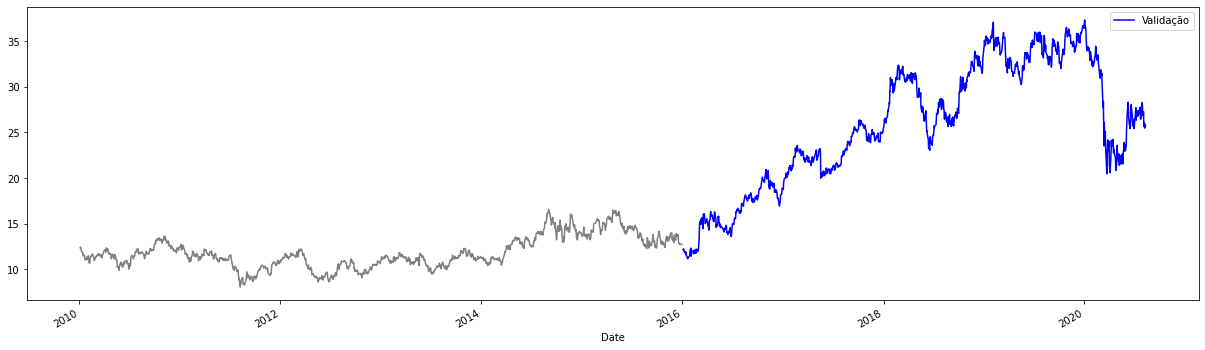

In [565]:
# Representação da separação em treino e validação
train_diario['ITUB4'].plot(color='gray', label='')
valid_diario['ITUB4'].plot(color='blue', label='Validação')
plt.legend()
plt.show();

#### Definição da métrica de avaliação

Iremos avaliar nossos modelos por meio da métrica RMSE.

In [540]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [541]:
metrica = rmse

#### Modelagem - Baseline

Vamos criar uma baseline bem simples, que será a média móvel dos retornos nos três dias anteriores. Essa baseline será importante para compararmos com os modelos mais sofisticados e verificarmos se eles conseguirão superá-la.

In [543]:
def roda_baseline(df, metrica):
    # Cria um dicionário para armazenar os resultados
    dict_results = dict()
    
    # Separa em treino e validação
    train, valid = split_train_valid(df, '2016-01-01')
    
    # Itera entre os tickers, faz as previsões e armazena os resultados
    for c in valid.columns:
        y_true = diario_pct[c].iloc[3:]
        y_pred = diario_pct[c].rolling(3).mean().shift(1).dropna()
        dict_results[f'baseline_{c}'] = metrica(y_true, y_pred)
    
    return dict_results

In [549]:
# Roda os baselines e computa as métricas
baseline_diario_results = roda_baseline(df=diario_pct, metrica=metrica)
baseline_semanal_results = roda_baseline(df=semanal_pct, metrica=metrica)
baseline_mensal_results = roda_baseline(df=mensal_pct, metrica=metrica)

#### Modelagem - ARIMA

In [884]:
def roda_arima(df, order, metrica):
    # Cria um dicionário para armazenar os resultados
    dict_results = dict()
    
    for c in df.columns:
        # Cria uma tabela auxiliar
        aux = df[c].copy()
        
        # Separa em treino e validação
        train, valid = split_train_valid(aux, '2016-01-01')
        
        y_pred = []
        y_true = valid.values
        dates = valid.index.to_list()
        i = 1
        
        print(c)
        
        for date in dates:
            
            print('rodando', i, 'de', len(dates))
            
            # Ajusta o ARIMA
            arima = ARIMA(train, order=order)
            arima_fitted = arima.fit()
            
            # Adiciona a previsão do dado na lista
            y_pred.append(arima_fitted.predict(start=0, end=0)[0])
            # print(y_pred)

            # Removendo a observação de treino antiga
            train.drop(train.index.min(), axis=0, inplace=True)

            # Adicionando a nova observação de treino
            new_train = valid[valid.index == date]
            train = pd.concat([train, new_train], axis=0)
            # break
            
            # Removendo a primeira observação da base 'valid'
            valid.drop(valid.index.min(), inplace=True)
            
            i+=1
        
        # Armazena os resultados
        dict_results[c] = metrica(y_true, y_pred)

    return dict_results

In [878]:
# Roda o arima e computa as métricas
arima_diario_results = roda_arima(df=diario_pct, order=(1, 0, 1), metrica=metrica)
arima_semanal_results = roda_arima(df=semanal_pct, order=(1, 0, 1), metrica=metrica)
arima_mensal_results = roda_arima(df=mensal_pct, order=(1, 0, 1), metrica=metrica)

#### Criando features para modelos de Machine Learning

In [730]:
def cria_variaveis(df):
    new_df = df.copy()
    new_df.loc[:,'weekday'] = new_df.index.dayofweek
    new_df.loc[:,'lag_1'] = new_df.iloc[:, 0].shift(1)
    new_df.loc[:,'lag_2'] = new_df.iloc[:, 0].shift(2)
    new_df.loc[:,'lag_3'] = new_df.iloc[:, 0].shift(3)
    new_df.loc[:,'lag_4'] = new_df.iloc[:, 0].shift(4)
    new_df.loc[:,'lag_5'] = new_df.iloc[:, 0].shift(5)
    new_df.loc[:,'lag_6'] = new_df.iloc[:, 0].shift(6)
    
    X = new_df.drop(df.columns, axis=1).fillna(method='backfill')
    y = new_df[df.columns]
    
    return X, y

#### Modelagem - Regressão Linear

In [733]:
def roda_reg_linear(df, metrica):
    # Cria um dicionário para armazenar os resultados
    dict_results = dict()
    
    for c in df.columns:
        # Cria uma tabela auxiliar
        aux = pd.DataFrame(df[c].copy())
        
        # Separa em treino e validação
        train, valid = split_train_valid(aux, '2016-01-01')
        
        # Separa em X e y
        X_train, y_train = cria_variaveis(pd.DataFrame(train))
        X_valid, y_valid = cria_variaveis(pd.DataFrame(valid))
        
        # Instanciando o modelo
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        
        # Predizendo os dados de validação
        y_pred = lr.predict(X_valid)
        
        # Calcula e armazena o erro
        erro = metrica(np.array(valid), y_pred)
        dict_results[c] = erro
    
    return dict_results

In [735]:
# Roda a regressão linear e computa as métricas
lr_diario_results = roda_reg_linear(df=diario_pct, metrica=metrica)
lr_semanal_results = roda_reg_linear(df=semanal_pct, metrica=metrica)
lr_mensal_results = roda_reg_linear(df=mensal_pct, metrica=metrica)

#### Modelagem - Random Forest

In [737]:
def roda_random_forest(df, metrica):
    # Cria um dicionário para armazenar os resultados
    dict_results = dict()
    
    for c in df.columns:
        # Cria uma tabela auxiliar
        aux = pd.DataFrame(df[c].copy())
        
        # Separa em treino e validação
        train, valid = split_train_valid(aux, '2016-01-01')
        
        # Separa em X e y
        X_train, y_train = cria_variaveis(pd.DataFrame(train))
        X_valid, y_valid = cria_variaveis(pd.DataFrame(valid))
        
        # Instanciando o modelo
        rf = RandomForestRegressor(n_estimators=1000, min_samples_split=20, random_state=42)
        rf.fit(X_train, y_train)
        
        # Predizendo os dados de validação
        y_pred = rf.predict(X_valid)
        
        # Calcula e armazena o erro
        erro = metrica(np.array(valid), y_pred)
        dict_results[c] = erro
    
    return dict_results

In [738]:
# Roda a regressão linear e computa as métricas
rf_diario_results = roda_random_forest(df=diario_pct, metrica=metrica)
rf_semanal_results = roda_random_forest(df=semanal_pct, metrica=metrica)
rf_mensal_results = roda_random_forest(df=mensal_pct, metrica=metrica)

#### Comparação de resultados

Lembrando que estamos medindo apenas o erro, e não retorno financeiro. Nem sempre o modelo que apresenta o menor erro nas previsões será o mais lucrativo. É necessário fazer essa medição, também, e comparar as abordagens.

In [894]:
def cria_df_results(ticker):
    
    columns = ['Modelo', 'RMSE_Diario', 'RMSE_Semanal', 'RMSE_Mensal']
    
    results = pd.DataFrame(columns=columns)
    
    # Baseline
    baseline_model = 'Baseline'
    baseline_diario = baseline_diario_results[[i for i in baseline_diario_results if ticker in i][0]]
    baseline_semanal = baseline_semanal_results[[i for i in baseline_semanal_results if ticker in i][0]]
    baseline_mensal = baseline_mensal_results[[i for i in baseline_mensal_results if ticker in i][0]]
    df_baseline = pd.DataFrame([baseline_model, baseline_diario, baseline_semanal, baseline_mensal], index=columns).T
    results = pd.concat([results, df_baseline])
    
    # ARIMA
    arima_model = 'ARIMA'
    arima_diario = arima_diario_results[[i for i in arima_diario_results if ticker in i][0]]
    arima_semanal = arima_semanal_results[[i for i in arima_semanal_results if ticker in i][0]]
    arima_mensal = arima_mensal_results[[i for i in arima_mensal_results if ticker in i][0]]
    df_arima = pd.DataFrame([arima_model, arima_diario, arima_semanal, arima_mensal], index=columns).T
    results = pd.concat([results, df_arima])
    
    # Linear Regression
    lr_model = 'Linear Regression'
    lr_diario = lr_diario_results[[i for i in lr_diario_results if ticker in i][0]]
    lr_semanal = lr_semanal_results[[i for i in lr_semanal_results if ticker in i][0]]
    lr_mensal = lr_mensal_results[[i for i in lr_mensal_results if ticker in i][0]]
    df_lr = pd.DataFrame([lr_model, lr_diario, lr_semanal, lr_mensal], index=columns).T
    results = pd.concat([results, df_lr])

    # Random Forest
    rf_model = 'Random Forest'
    rf_diario = rf_diario_results[[i for i in rf_diario_results if ticker in i][0]]
    rf_semanal = rf_semanal_results[[i for i in rf_semanal_results if ticker in i][0]]
    rf_mensal = rf_mensal_results[[i for i in rf_mensal_results if ticker in i][0]]
    df_rf = pd.DataFrame([rf_model, rf_diario, rf_semanal, rf_mensal], index=columns).T
    results = pd.concat([results, df_rf])
    
    return results

In [895]:
itub_results = cria_df_results('ITUB4')
bbdc_results = cria_df_results('BBDC4')
bbas_results = cria_df_results('BBAS3')
sanb_results = cria_df_results('SANB11')

In [899]:
itub_results

Modelo RMSE_Diario RMSE_Semanal RMSE_Mensal
0           Baseline   0.0233885    0.0233885   0.0233885
0              ARIMA   0.0213213    0.0446315   0.0890486
0  Linear Regression   0.0213631    0.0446225   0.0928433
0      Random Forest   0.0217491    0.0445731   0.0902701

#### Análise de resíduos

def plot_residuos():